In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_face_mask_detection_path = kagglehub.dataset_download('andrewmvd/face-mask-detection')

print('Data source import complete.')


Data source import complete.


## Import the Necessary Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET

## Prepare the Dataset

In [ ]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [ ]:
ANNOTATION_PATH = '/kaggle/input/face-mask-detection/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH)]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

In [ ]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('/kaggle/input/face-mask-detection/images/maksssksksss0.png', parse_xml('/kaggle/input/face-mask-detection/annotations/maksssksksss0.xml'))

In [ ]:
IMAGE_PATH = '/kaggle/input/face-mask-detection/images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

for i in range(len(df)):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

face_images = np.array(face_images, dtype='float32')
face_labels = np.array(face_labels)

In [ ]:
augmentation = ImageDataGenerator(
    zoom_range = 0.1,
    shear_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rotation_range = 25,
    fill_mode = 'nearest'
)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(face_images, face_labels, test_size=0.2,  stratify=face_labels)


## Define the Model

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    augmentation.flow(train_x, train_y, batch_size=16),
    validation_data = (test_x, test_y),
    epochs = 5
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 106s 395ms/step - accuracy: 0.7624 - loss: 9.8786 - val_accuracy: 0.8147 - val_loss: 0.8538
Epoch 2/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 48s 235ms/step - accuracy: 0.8739 - loss: 0.4681 - val_accuracy: 0.8810 - val_loss: 0.3521
Epoch 3/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 47s 231ms/step - accuracy: 0.8899 - loss: 0.4002 - val_accuracy: 0.9067 - val_loss: 0.2294
Epoch 4/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 50s 243ms/step - accuracy: 0.9017 - loss: 0.3196 - val_accuracy: 0.8933 - val_loss: 0.3521
Epoch 5/5
204/204 ━━━━━━━━━━━━━━━━━━━━ 48s 233ms/step - accuracy: 0.9133 - loss: 0.2915 - val_accuracy: 0.9337 - val_loss: 0.2386


In [ ]:
model.save('mask_detection.h5')

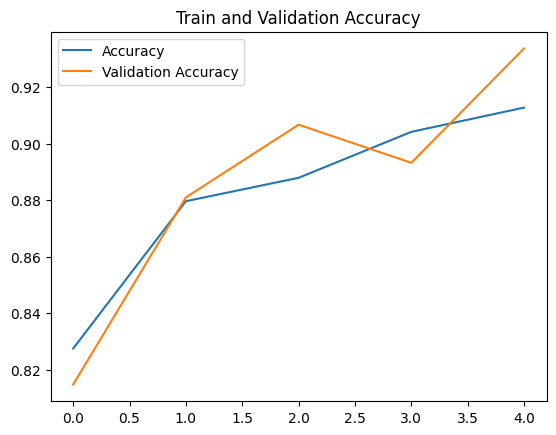

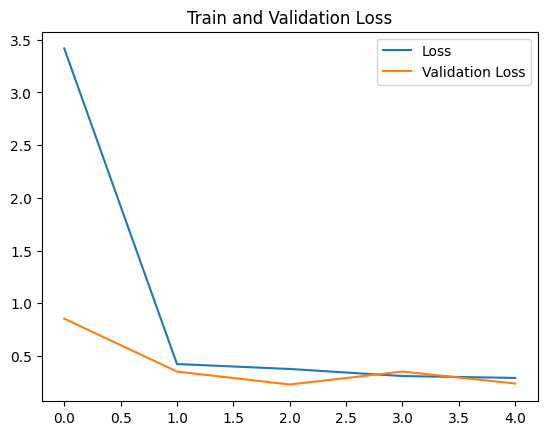

In [ ]:
plt.figure()
plt.title('Train and Validation Accuracy')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.figure()
plt.title('Train and Validation Loss')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2025-04-28 12:54:12--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt.1’

deploy.prototxt.1   100%[===================>]  27.45K  --.-KB/s    in 0s      

2025-04-28 12:54:12 (56.2 MB/s) - ‘deploy.prototxt.1’ saved [28104/28104]

--2025-04-28 12:54:12--  https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/opencv/opencv_3rdparty/d

In [ ]:
import os
print(os.listdir('/kaggle/working'))


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working'

In [ ]:
import os
print(os.getcwd())


/content


In [ ]:
print(os.listdir())


['.config', 'mask_detection.h5', 'res10_300x300_ssd_iter_140000.caffemodel.1', 'res10_300x300_ssd_iter_140000.caffemodel', 'deploy.prototxt.1', 'deploy.prototxt', 'sample_data']


In [ ]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt -P /kaggle/working/
!wget https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel -P /kaggle/working/


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


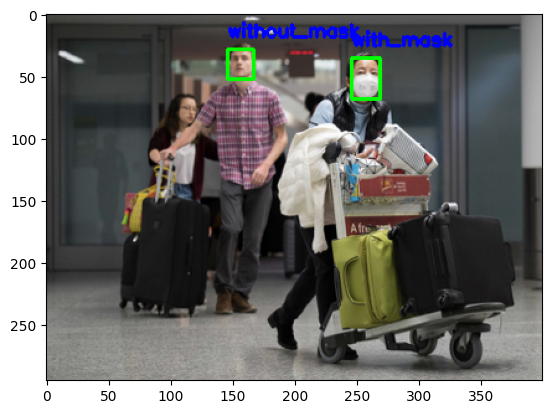

In [ ]:
# model_path = "/kaggle/working/deploy.prototxt"  # Replace with your prototxt path
# weights_path = "/kaggle/working/res10_300x300_ssd_iter_140000.caffemodel"  # Replace with your caffemodel path
# face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)
model_path = "/content/deploy.prototxt"  # Correct path
weights_path = "/content/res10_300x300_ssd_iter_140000.caffemodel"  # Correct path
face_net = cv2.dnn.readNetFromCaffe(model_path, weights_path)

label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}
def predict_image(filepath):
    image = cv2.imread(filepath)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300), mean=(104.0, 177.0, 123.0))
    face_net.setInput(blob)
    detections = face_net.forward()
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # faces = face_cascade.detectMultiScale(gray, 1.13, 2)

    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.2:  # Threshold for confidence
            box = detections[0, 0, i, 3:7] * [w, h, w, h]
            (startX, startY, endX, endY) = box.astype("int")
            face = image[startY:endY, startX:endX]
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = tf.expand_dims(face, axis=0)
            face = preprocess_input(face)
            label = model.predict(face)
            label = np.argmax(label, axis=1)[0]
            cv2.putText(image, label_pair_reversed[label], (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
    # for (x, y, w, h) in faces:
    #     face = image[y:y+h, x:x+w]
    #     face = cv2.resize(image, (224, 224))
    #     face = img_to_array(face)
    #     face = tf.expand_dims(face, axis=0)
    #     face = preprocess_input(face)
    #     label = model.predict(face)
    #     print(label)
    #     # label = tf.argmax(label)

    #     cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

predict_image('/kaggle/input/face-mask-detection/images/maksssksksss129.png')

In [ ]:
!pip install tensorflow opencv-python


In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

# Load your models
face_net = cv2.dnn.readNetFromCaffe('deploy.prototxt', 'res10_300x300_ssd_iter_140000.caffemodel')
model = load_model('mask_detection.h5')

label_pair_reversed = {
    0: 'with_mask',
    1: 'without_mask',
    2: 'mask_weared_incorrect'
}

# Function to capture image from webcam
def capture_image():
    js = Javascript('''
    async function capturePhoto() {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize video
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getTracks().forEach(track => track.stop());
      div.remove();
      return canvas.toDataURL('image/jpeg', 1.0);
    }
    capturePhoto();
    ''')
    display(js)
    data = eval_js('capturePhoto()')
    binary = b64decode(data.split(',')[1])
    img = Image.open(io.BytesIO(binary))
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Capture Image
frame = capture_image()

# Detection
(h, w) = frame.shape[:2]
blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_net.setInput(blob)
detections = face_net.forward()

for i in range(0, detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > 0.5:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        startX = max(0, startX)
        startY = max(0, startY)
        endX = min(w - 1, endX)
        endY = min(h - 1, endY)

        face = frame[startY:endY, startX:endX]
        if face.size == 0:
            continue

        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)

        pred = model.predict(face, verbose=0)
        label = np.argmax(pred, axis=1)[0]
        label_text = label_pair_reversed[label]

        color = (0, 255, 0) if label == 0 else (0, 0, 255)
        cv2.putText(frame, label_text, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

# Show output
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


error: OpenCV(4.11.0) /io/opencv/modules/dnn/src/caffe/caffe_io.cpp:1126: error: (-2:Unspecified error) FAILED: fs.is_open(). Can't open "deploy.prototxt" in function 'ReadProtoFromTextFile'
